# Machine Learning Engineer Nanodegree - Capstone Project

## Santander Customer Transaction Prediction

This project's objective is to predict whether a customer will make a specific transaction in the future or not, regardless of the amount of money transacted. To achieve this objective we'll be using anonymized data consisting of 200 features, 200k observations for training and another 200k for testing.

### Loading data

In [1]:
# Importing main libraries for the project
# Other eventual libraries will be imported on demand
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display # to use display() for DataFrames
from warnings import filterwarnings

# Loading training and testing data
training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")

# Separating features and targets
training_features = training_data.drop(['ID_code', 'target'], axis=1)
training_targets = training_data[['target']]

testing_features = testing_data.drop(['ID_code'], axis=1)

# Loading sample submission data
submission = pd.read_csv('sample_submission.csv')

# Peeking at first 10 observations
display(training_data.head(n=10))

# Ignoring deprecation and future warnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


### Data Exploration and Visualization

Total number of customers: 200000
Customers that will not make future transactions: 179902
Customers that will make future transactions: 20098
Percentage of customers tha will make future transactions: 10.049%


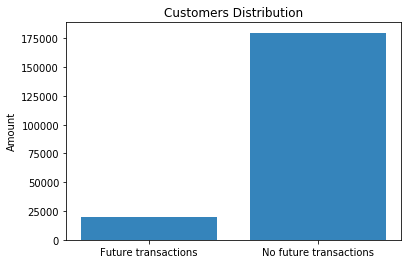

In [2]:
# Checking if data is balanced

# Number of customers
n_cust = training_data.shape[0]

# Number of customers that will not make future transactions
n_no_fut_trans = training_data[training_data["target"] == 0].shape[0]

# Number of customers that will make future transactions
n_fut_trans = training_data[training_data["target"] == 1].shape[0]

positions = [0.5, 1.5]
customers = [n_fut_trans, n_no_fut_trans]
labels = ['Future transactions', 'No future transactions' ]

plt.bar(positions, customers, align='center', alpha=0.9)
plt.xticks(positions, labels)
plt.ylabel('Amount')
plt.title('Customers Distribution')

print("Total number of customers: {}".format(n_cust))
print("Customers that will not make future transactions: {}".format(n_no_fut_trans))
print("Customers that will make future transactions: {}".format(n_fut_trans))
print("Percentage of customers tha will make future transactions: {}%".format(n_fut_trans/n_cust*100))

C:\Users\bonav\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


Number of normally distributted variables: 0
Number of not normally distributted variables: 200


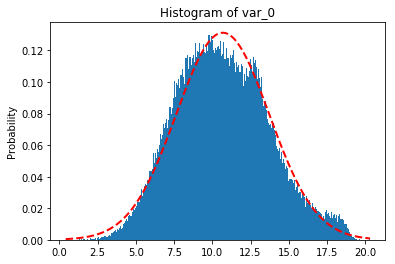

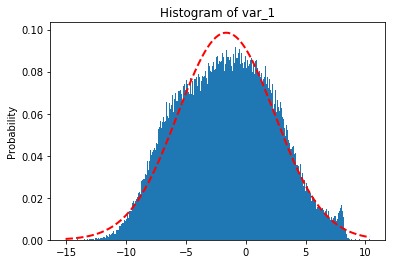

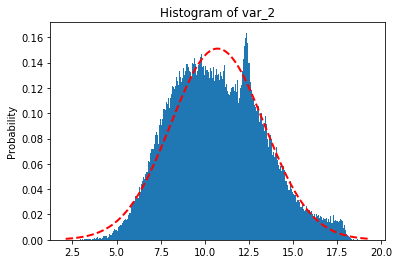

In [3]:
# Check training features distributions
from collections import defaultdict
import matplotlib.mlab as mlab
from scipy.stats import norm, normaltest

figs = defaultdict()
hists = defaultdict()
best_fits = defaultdict()

normal_features = []
not_normal_features = []

i = 0
# significance level of 5%
alpha = 0.05
for col in training_features.columns: 
    figs[col] = plt.figure()
    
    hists[col] = figs[col].add_subplot(1,1,1)
    n, bins, patches = hists[col].hist(training_features[col], bins=500, density=1)
    hists[col].set_ylabel('Probability')
    hists[col].set_title('Histogram of {}'.format(col))
    
    (mu, sigma) = norm.fit(training_features[col])
    
    best_fits[col] = mlab.normpdf(bins, mu, sigma) 
    plt.plot(bins, best_fits[col], 'r--', linewidth=2)
        
    i += 1
    if i == 3:
        break

for col in training_features.columns: 

    stat, p = normaltest(training_features[col])

    if p > alpha:
        normal_features.append(col)
    else:
        not_normal_features.append(col)

print('Number of normally distributted variables: {}'.format(len(normal_features)))
print('Number of not normally distributted variables: {}'.format(len(not_normal_features)))

In [4]:
# Checking features correlation
correlations_matrix = training_features.corr()

strong_corr = []
medium_corr = []
weak_corr = []
no_corr = []

features = training_features.columns

for i, row in enumerate(features):
    for j, col in enumerate(features):
        
        if i <= j:
            continue
            
        current_features = (features[i], features[j])
        
        if(abs(correlations_matrix.loc[row,col]) > 0.7):
            strong_corr.append(current_features)
        elif(abs(correlations_matrix.loc[row,col]) > 0.4):
            medium_corr.append(current_features)
        elif(abs(correlations_matrix.loc[row,col]) > 0.2):    
            weak_corr.append(current_features)
        else:
            no_corr.append(current_features)
    
print('Number of strong correlations: {}'.format(len(strong_corr)))
print('Number of medium correlations: {}'.format(len(medium_corr)))
print('Number of weak correlations: {}'.format(len(weak_corr)))
print('Number of no correlations: {}'.format(len(no_corr)))

Number of strong correlations: 0
Number of medium correlations: 0
Number of weak correlations: 0
Number of no correlations: 19900


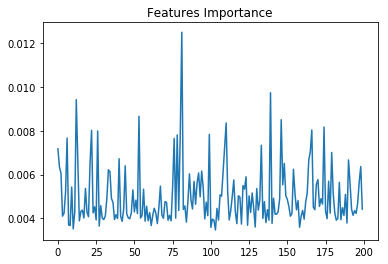

In [5]:
# Checking features importance
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(training_features, np.ravel(training_targets, order='C'))

fig = plt.figure()
graphic = fig.add_subplot(1,1,1)
graphic.set_title('Features Importance')
plt.plot(rf.feature_importances_)
# Next line plots features names on x axis, but too many features make them kinda cramped
# plt.xticks(np.arange(training_features.shape[1]), training_features.columns.tolist(), rotation=90)

In [6]:
# Outlier detection (Turkey's method)
outliers_t  = []
repeated = []

# For each feature 
for feature in training_features.columns:
    
    # Calculate first quartile
    Q1 = np.percentile(training_features[feature], 25)
    
    # Calculate
    Q3 = np.percentile(training_features[feature], 75)
    
    # Calculate interquatile range * 1.5
    step = (Q3-Q1)*1.5
    
    for i in list((training_features[~((training_features[feature] >= Q1 - step) & (training_features[feature] <= Q3 + step))]).index.values):
        if i not in outliers_t:
            outliers_t.append(i)
        elif i not in repeated:
            repeated.append(i)


# Printing outliers amount and percentages
print("Number of points considered outliers in multiple features: {}".format(len(repeated)))
print("Number of points considered outliers in any feature: {}".format(len(outliers_t)))

print("Percentage of outliers in multiple features: {0:0.3f}%".format(len(repeated)/n_cust*100))
print("Percentage of outliers in any feature: {0:0.3f}%".format(len(outliers_t)/n_cust*100))

Number of points considered outliers in multiple features: 1556
Number of points considered outliers in any feature: 24896
Percentage of outliers in multiple features: 0.778%
Percentage of outliers in any feature: 12.448%


In [7]:
# Outlier detection (Local Outlier Factor)
# Not viable due to O(n²) complexity, takes too long as a result of dataset size
# Kept for future reference only

# from sklearn.neighbors import LocalOutlierFactor

# lof = LocalOutlierFactor()

# outliers_l = lof.fit_predict(X)

# print("Number of points considered outliers: {}".format(len(outliers_l[outliers_l == -1])))

In [8]:
# Checking for any missing values on training and testing data

tr_nans = training_data.isnull().any().any()
te_nans = testing_data.isnull().any().any()

print('Missing any data on training set: {}'.format(tr_nans))
print('Missing any data on testing set: {}'.format(te_nans))

Missing any data on training set: False
Missing any data on testing set: False


### Data pre-processing 

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Removing some outliers from original data 
filtered_training_features = training_features.drop(repeated)
filtered_training_targets = training_targets.drop(repeated)

# training data
scaler.fit(training_features)
scale_training_features = scaler.transform(training_features)

# testing data
scaler.fit(testing_features)
scale_testing_features = scaler.transform(testing_features)

### Data balancing and Cross-validation

In [10]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Used for oversampling
smt = SMOTE()

# Used for undersampling
tomek = TomekLinks()

# Combine oversampling and undersampling
smt_tomek =SMOTETomek() 

# Used for cross-validation
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

### Benchmark model

In [36]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import roc_auc_score

results_train = np.empty((0,0))
results_test = np.empty((0,0))

print('Benchmark model training/predicting')

for train_index, test_index in skf.split(scale_training_features, training_targets):

        # Separating training and testing data
        X_train, X_test = scale_training_features[train_index], scale_training_features[test_index]
        y_train, y_test = training_targets.iloc[train_index], training_targets.iloc[test_index]
        
        bench_model = ComplementNB()
        bench_model.fit(X_train, np.ravel(y_train, order='C'))
        
        predictions_train = bench_model.predict(X_train)
        predictions_test = bench_model.predict(X_test)

        train_auc = roc_auc_score(y_train, predictions_train)
        test_auc = roc_auc_score(y_test, predictions_test)

        results_train = np.append(results_train, train_auc)
        results_test = np.append(results_test, test_auc)

print('Average results:\n')

print("[training] Area under ROC curve: {}".format(np.mean(results_train)))
print("[testing] Area under ROC curve: {}".format(np.mean(results_test)))

Benchmark model training/predicting
Average results:

[training] Area under ROC curve: 0.7771395283163944
[testing] Area under ROC curve: 0.7756501878732454


### Pipeline functions

In [12]:
from sklearn.metrics import roc_auc_score, fbeta_score
from time import time

# Function used for the classifiers pipeline
def train_predict(classifier, X_train, y_train, X_test, y_test, sample_size=-1):
   
    results = {}
    
    if(sample_size == -1):
        sample_size = X_train.shape[0]
        
    start = time() # Get training start time
    classifier = classifier.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get training end time
    
    # Storing training time
    results['train_time'] = end-start
    
    start = time() # Get predictions start time
    predictions_test = classifier.predict(X_test)
    predictions_train = classifier.predict(X_train)
    end = time() # Get predictions end time
    
    results['pred_time'] = end-start
    
    # Compute area under the receive operating characterist curve using roc_auc_acore
    results['roc_train'] = roc_auc_score(y_train, predictions_train)
    results['roc_test'] = roc_auc_score(y_test, predictions_test)
    
    # Compute F-score using fbeta_score
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=2)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=2)
    
    return results


In [13]:
# Code adapted from an udacity machine learning engineer nanodegree project 
def evaluate(results, roc_auc, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 4, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'roc_train', 'f_train', 'pred_time', 'roc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("ROC AUC Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("ROC AUC Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("ROC AUC on Training set")
    ax[0, 2].set_title("F-score on Training set")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("ROC AUC Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for predictors
    ax[0, 1].axhline(y = roc_auc, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = roc_auc, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Set additional plots invisibles
    ax[0, 3].set_visible(False)
    ax[1, 3].axis('off')

    # Create legend
    for i, learner in enumerate(results.keys()):
        plt.bar(0, 0, color=colors[i], label=learner)
    plt.legend()
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [14]:
from collections import defaultdict

# Calculate the mean of kfold partitions metrics
def mean_result(results):
    
    final_results = defaultdict(dict)
    
    for clf, data in results.items():
        classifier_data = data
        
        for size, values in classifier_data.items():
            results = values
            
            train_time = 0.0
            pred_time = 0.0
            roc_train = 0.0
            roc_test = 0.0
            f_train = 0.0
            f_test = 0.0
            
            
            for fold_result in results:
                train_time += fold_result['train_time']
                pred_time += fold_result['pred_time']
                roc_train += fold_result['roc_train']
                roc_test += fold_result['roc_test']
                f_train += fold_result['f_train']
                f_test += fold_result['f_test']
            
            train_time /= len(results)
            pred_time /= len(results)
            roc_train /= len(results)
            roc_test /= len(results)
            f_train /= len(results)
            f_test /= len(results)
            
            result = {'train_time': train_time, 'pred_time': pred_time, \
                      'roc_train': roc_train, 'roc_test': roc_test, \
                      'f_train': f_train, 'f_test': f_test}
            
            final_results[clf][size] = result

    return final_results

### Supervised Learning Pipeline

In [16]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# liblinear is the default solver for logistic regression at the time of this implementation
clf_A = LogisticRegression(solver='liblinear', random_state=42)
clf_B = XGBClassifier()
clf_C = RandomForestClassifier(random_state=42)

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = defaultdict(lambda: [])
    j = 0
    for train_index, test_index in skf.split(training_features, training_targets):

        # Separating training and testing data
        X_train, X_test = training_features.iloc[train_index], training_features.iloc[test_index]
        y_train, y_test = training_targets.iloc[train_index], training_targets.iloc[test_index]

        size_1 = int(0.01 * X_train.shape[0])
        size_10 =int(0.1 * X_train.shape[0])
        size_100 = X_train.shape[0]

        for i, samples in enumerate([size_1, size_10, size_100]):
            results[clf_name][i].append(train_predict(clf, X_train, np.ravel(y_train, order='C'), X_test, np.ravel(y_test, order='C'), samples))
        j += 1


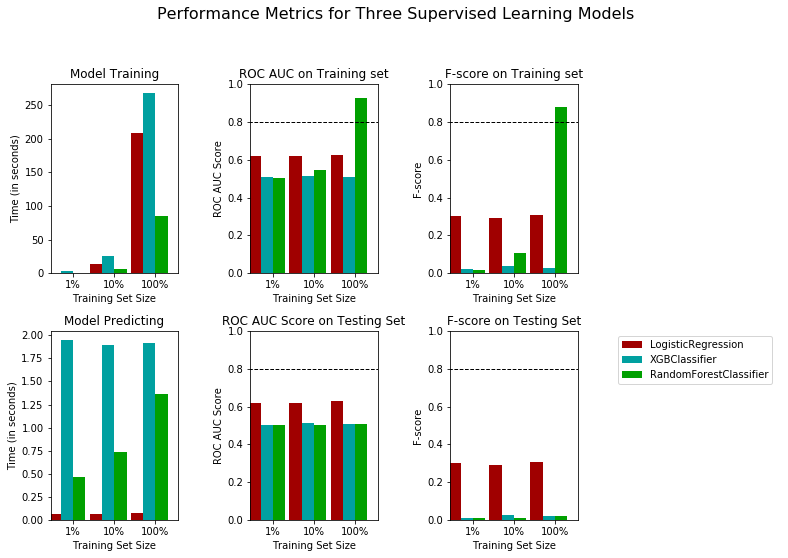

Models performance on full data set:

LogisticRegression 
 Time - Training: 208.53424754142762 	 Testing: 0.07439646720886231 
 ROC AUC - Train: 0.6284147405518116 	 Test: 0.6273054845820759 
 F-Score: Train: 0.30783219597104977 	 Test: 0.30547897917730016
XGBClassifier 
 Time - Training: 267.6871225833893 	 Testing: 1.915584349632263 
 ROC AUC - Train: 0.5117646595517966 	 Test: 0.5075846885210766 
 F-Score: Train: 0.029336337128566335 	 Test: 0.01907530907921972
RandomForestClassifier 
 Time - Training: 85.07812938690185 	 Testing: 1.3613678216934204 
 ROC AUC - Train: 0.9270650786610736 	 Test: 0.508039727489781 
 F-Score: Train: 0.8797905930905806 	 Test: 0.02184451501772746


In [17]:
# Calculating results mean
final_results = mean_result(results)

# Run metrics visualization for the three supervised learning models chosen
evaluate(final_results, 0.8, 0.8)

# Checking numeric values for each method used (complete training set)
print("Models performance on full data set:\n")
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    print("{} \n Time - Training: {} \t Testing: {} \n ROC AUC - Train: {} \t Test: {} \n F-Score: Train: {} \t Test: {}" \
          .format(clf_name, \
          final_results[clf_name][2]['train_time'],final_results[clf_name][2]['pred_time'], \
          final_results[clf_name][2]['roc_train'],final_results[clf_name][2]['roc_test'], \
          final_results[clf_name][2]['f_train'], final_results[clf_name][2]['f_test']))

In [18]:
import lightgbm as lgb

results_train = np.empty((0,0))
results_test = np.empty((0,0))

for index, (train_index, test_index) in enumerate(skf.split(training_features, training_targets)):
    
        X_train, X_test = training_features.iloc[train_index], training_features.iloc[test_index]
        y_train, y_test = training_targets.iloc[train_index], training_targets.iloc[test_index]

        # Creating dataset for classifier 
        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test)
        
        param = {}
        
        model = lgb.train(param, train_data, valid_sets = [train_data, test_data])
        
        predictions_train = model.predict(X_train, num_iteration=model.best_iteration)
        predictions_test = model.predict(X_test, num_iteration=model.best_iteration)
        
        train_auc = roc_auc_score(y_train, predictions_train)
        test_auc = roc_auc_score(y_test, predictions_test)
        
        results_train = np.append(results_train, train_auc)
        results_test = np.append(results_test, test_auc)
        
print("Average train ROC AUC: {}".format(np.mean(results_train)))
print("Average test ROC AUC: {}".format(np.mean(results_test)))

Average train ROC AUC: 0.908269971424347
Average test ROC AUC: 0.854537827894255


### Unsupervised Learning 

In [11]:
from time import time
from sklearn.metrics import roc_auc_score

def knc_train_predict(classifier, X_train, y_train, X_test, y_test):
    
    results = {}
    
    start = time()
    classifier.fit(X_train, y_train)
    end = time()
    
    results['train_time'] = end - start
    
    start = time()
    pred_train = classifier.predict(X_train)
    pred_test = classifier.predict(X_test)
    end = time()
    
    results['pred_time'] = end - start
    
    # Compute area unders the receive operating characterist curve using roc_auc_acore
    results['roc_train'] = roc_auc_score(y_train, pred_train)
    results['roc_test'] = roc_auc_score(y_test, pred_test)
    
    return results


In [12]:
def average_results(results):
    
    train_time = 0.0
    pred_time = 0.0
    roc_train = 0.0
    roc_test = 0.0
    
    
    for clf in results:
        size = len(results[clf])
        for result in results[clf]:
            train_time += result['train_time']/size
            pred_time += result['pred_time']/size
            roc_train += result['roc_train']/size
            roc_test += result['roc_test']/size

    return train_time, pred_time, roc_train, roc_test

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict

clf = KNeighborsClassifier()

results = defaultdict(lambda: [])

clf_name = clf.__class__.__name__

size = int(0.1 * scale_training_features.shape[0])
random_scale = scale_training_features[:size]
random_targets = training_targets[:size]
    
i = 0

print('{} training/predicting\n'.format(clf_name))
for i, (train_index, test_index) in enumerate(skf.split(random_scale, random_targets)):
    
    # Separating training and testing data
    X_train, X_test = random_scale[train_index], random_scale[test_index]
    y_train, y_test = random_targets.iloc[train_index], random_targets.iloc[test_index]

    results[clf_name].append(knc_train_predict(clf, X_train, np.ravel(y_train, order='C'), X_test, np.ravel(y_test, order='C')))
    i += 1
    
train_time, pred_time, roc_train, roc_test = average_results(results)

print("Average measures\nTraining time: {}\tTesting time: {}\nROC AUC training: {}\t ROC AUC testing: {}".format(train_time, pred_time, roc_train, roc_test))

KNeighborsClassifier training/predicting

Average measures
Training time: 0.27231059074401853	Testing time: 200.57827060222624
ROC AUC training: 0.50563669497449	 ROC AUC testing: 0.5004521510961708


### LightGBM with tuned parameters

In [11]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

def lgbm_train_predict(training_features, training_targets, data_balance=None, size=-1, return_best_model=False):
    
    best_model = None
    best_test_accuracy = -np.inf
    
    results_train = np.empty((0,0))
    results_test = np.empty((0,0))

    pred_submission = 0
    
    if(size != -1):
        training_features = training_features.sample(n=size, random_state=42)
        training_targets = training_targets.loc[training_features.index, :]

    for index, (train_index, test_index) in enumerate(skf.split(training_features, training_targets)):

            print("Training fold {}".format(index+1))
            
            # Separating training and testing data
            X_train, X_test = training_features.iloc[train_index], training_features.iloc[test_index]
            y_train, y_test = training_targets.iloc[train_index], training_targets.iloc[test_index]

            # Creating dataset for classifier 
            train_data = lgb.Dataset(X_train, label=y_train)
            test_data = lgb.Dataset(X_test, label=y_test)
            
            param = {'random_state':42, 'metric': 'auc', 'bagging_freq': 5, 'bagging_fraction': 0.35,
                     'min_data_in_leaf': 256, 'learning_rate': 0.005, 'objective': 'binary', 'max_leaves': 80,
                     'num_threads': 4}
            
            if data_balance == None:
                param['is_unbalance'] = True
            elif data_balance == 'smt':
                X_train, y_train = smt.fit_resample(X_train, np.ravel(y_train,order='C'))
            elif data_balance == 'tomek':
                X_train, y_train = tomek.fit_resample(X_train, np.ravel(y_train,order='C'))
            elif data_balance == 'smt_tomek':
                X_train, y_train = smt_tomek.fit_resample(X_train, np.ravel(y_train,order='C'))
                
            model = lgb.train(param, train_data, 100000, valid_sets = [train_data, test_data], early_stopping_rounds=1024, verbose_eval=-1)

            predictions_train = model.predict(X_train, num_iteration=model.best_iteration)
            predictions_test = model.predict(X_test, num_iteration=model.best_iteration)

            train_auc = roc_auc_score(y_train, predictions_train)
            test_auc = roc_auc_score(y_test, predictions_test)

            results_train = np.append(results_train, train_auc)
            results_test = np.append(results_test, test_auc)

            submission_predictions = model.predict(testing_features, num_iteration=model.best_iteration)
            pred_submission += submission_predictions/n_folds
            
            if(best_test_accuracy < test_auc):
                best_test_accuracy = test_auc
                best_model = model


    print("Average train ROC AUC: {}".format(np.mean(results_train)))
    print("Average test ROC AUC: {}".format(np.mean(results_test)))
    
    if(return_best_model):
        return pred_submission, best_model
    return pred_submission

### Set choice

In [28]:
training_size = int(0.1 * training_features.shape[0])
# Set without outliers
filtered_set_predictions = lgbm_train_predict(filtered_training_features, filtered_training_targets, size=training_size)

Training fold 1
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3740]	training's auc: 0.99676	valid_1's auc: 0.865295
Training fold 2
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[2646]	training's auc: 0.991637	valid_1's auc: 0.836333
Training fold 3
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3450]	training's auc: 0.995229	valid_1's auc: 0.868268
Training fold 4
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[2724]	training's auc: 0.991819	valid_1's auc: 0.87218
Training fold 5
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3771]	training's auc: 0.996922	valid_1's auc: 0.872308
Training fold 6
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[8709]	training's auc: 0.999993	

In [29]:
training_size = int(0.1 * training_features.shape[0])
# Complete set
complete_set_predictions = lgbm_train_predict(training_features, training_targets, size=training_size)

Training fold 1
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4500]	training's auc: 0.998371	valid_1's auc: 0.877915
Training fold 2
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[7990]	training's auc: 0.999951	valid_1's auc: 0.872972
Training fold 3
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3105]	training's auc: 0.994006	valid_1's auc: 0.868122
Training fold 4
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4650]	training's auc: 0.998452	valid_1's auc: 0.861397
Training fold 5
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3740]	training's auc: 0.996369	valid_1's auc: 0.864999
Training fold 6
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3395]	training's auc: 0.99538

### Balance choice

In [14]:
training_size = int(0.1 * training_features.shape[0])
# Oversampling
print("Oversampling training data\n")
over_pred = lgbm_train_predict(filtered_training_features, filtered_training_targets,data_balance='smt', size=training_size)

Oversampling training data

Training fold 1
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[2588]	training's auc: 0.982715	valid_1's auc: 0.880858
Training fold 2
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4120]	training's auc: 0.995356	valid_1's auc: 0.848756
Training fold 3
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4507]	training's auc: 0.996432	valid_1's auc: 0.875883
Training fold 4
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3680]	training's auc: 0.992422	valid_1's auc: 0.883312
Training fold 5
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3100]	training's auc: 0.988407	valid_1's auc: 0.876423
Training fold 6
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3

In [15]:
training_size = int(0.1 * training_features.shape[0])
# Undersampling
print("\nUndersampling training data\n")
under_pred = lgbm_train_predict(filtered_training_features, filtered_training_targets,data_balance='tomek', size=training_size)


Undersampling training data

Training fold 1
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[2588]	training's auc: 0.982715	valid_1's auc: 0.880858
Training fold 2
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4120]	training's auc: 0.995356	valid_1's auc: 0.848756
Training fold 3
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4507]	training's auc: 0.996432	valid_1's auc: 0.875883
Training fold 4
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3680]	training's auc: 0.992422	valid_1's auc: 0.883312
Training fold 5
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3100]	training's auc: 0.988407	valid_1's auc: 0.876423
Training fold 6
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:


In [16]:
training_size = int(0.1 * training_features.shape[0])
# Combination of oversampling and undersampling
print("\nCombining oversampling and undersampling\n")
comb_pred = lgbm_train_predict(filtered_training_features, filtered_training_targets,data_balance='smt_tomek', size=training_size)


Combining oversampling and undersampling

Training fold 1
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[2588]	training's auc: 0.982715	valid_1's auc: 0.880858
Training fold 2
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4120]	training's auc: 0.995356	valid_1's auc: 0.848756
Training fold 3
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4507]	training's auc: 0.996432	valid_1's auc: 0.875883
Training fold 4
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3680]	training's auc: 0.992422	valid_1's auc: 0.883312
Training fold 5
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[3100]	training's auc: 0.988407	valid_1's auc: 0.876423
Training fold 6
Training until validation scores don't improve for 1024 rounds.
Early stopping, best i

### Final Model

In [13]:
print("Final Model\n")
predictions, best_model = lgbm_train_predict(filtered_training_features, filtered_training_targets, return_best_model=True)

Final Model

Training fold 1
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[5170]	training's auc: 0.992497	valid_1's auc: 0.902482
Training fold 2
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4630]	training's auc: 0.989701	valid_1's auc: 0.886957
Training fold 3
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4416]	training's auc: 0.98844	valid_1's auc: 0.900626
Training fold 4
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4495]	training's auc: 0.988987	valid_1's auc: 0.896955
Training fold 5
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[4705]	training's auc: 0.990186	valid_1's auc: 0.890286
Training fold 6
Training until validation scores don't improve for 1024 rounds.
Early stopping, best iteration is:
[5610]	training's 

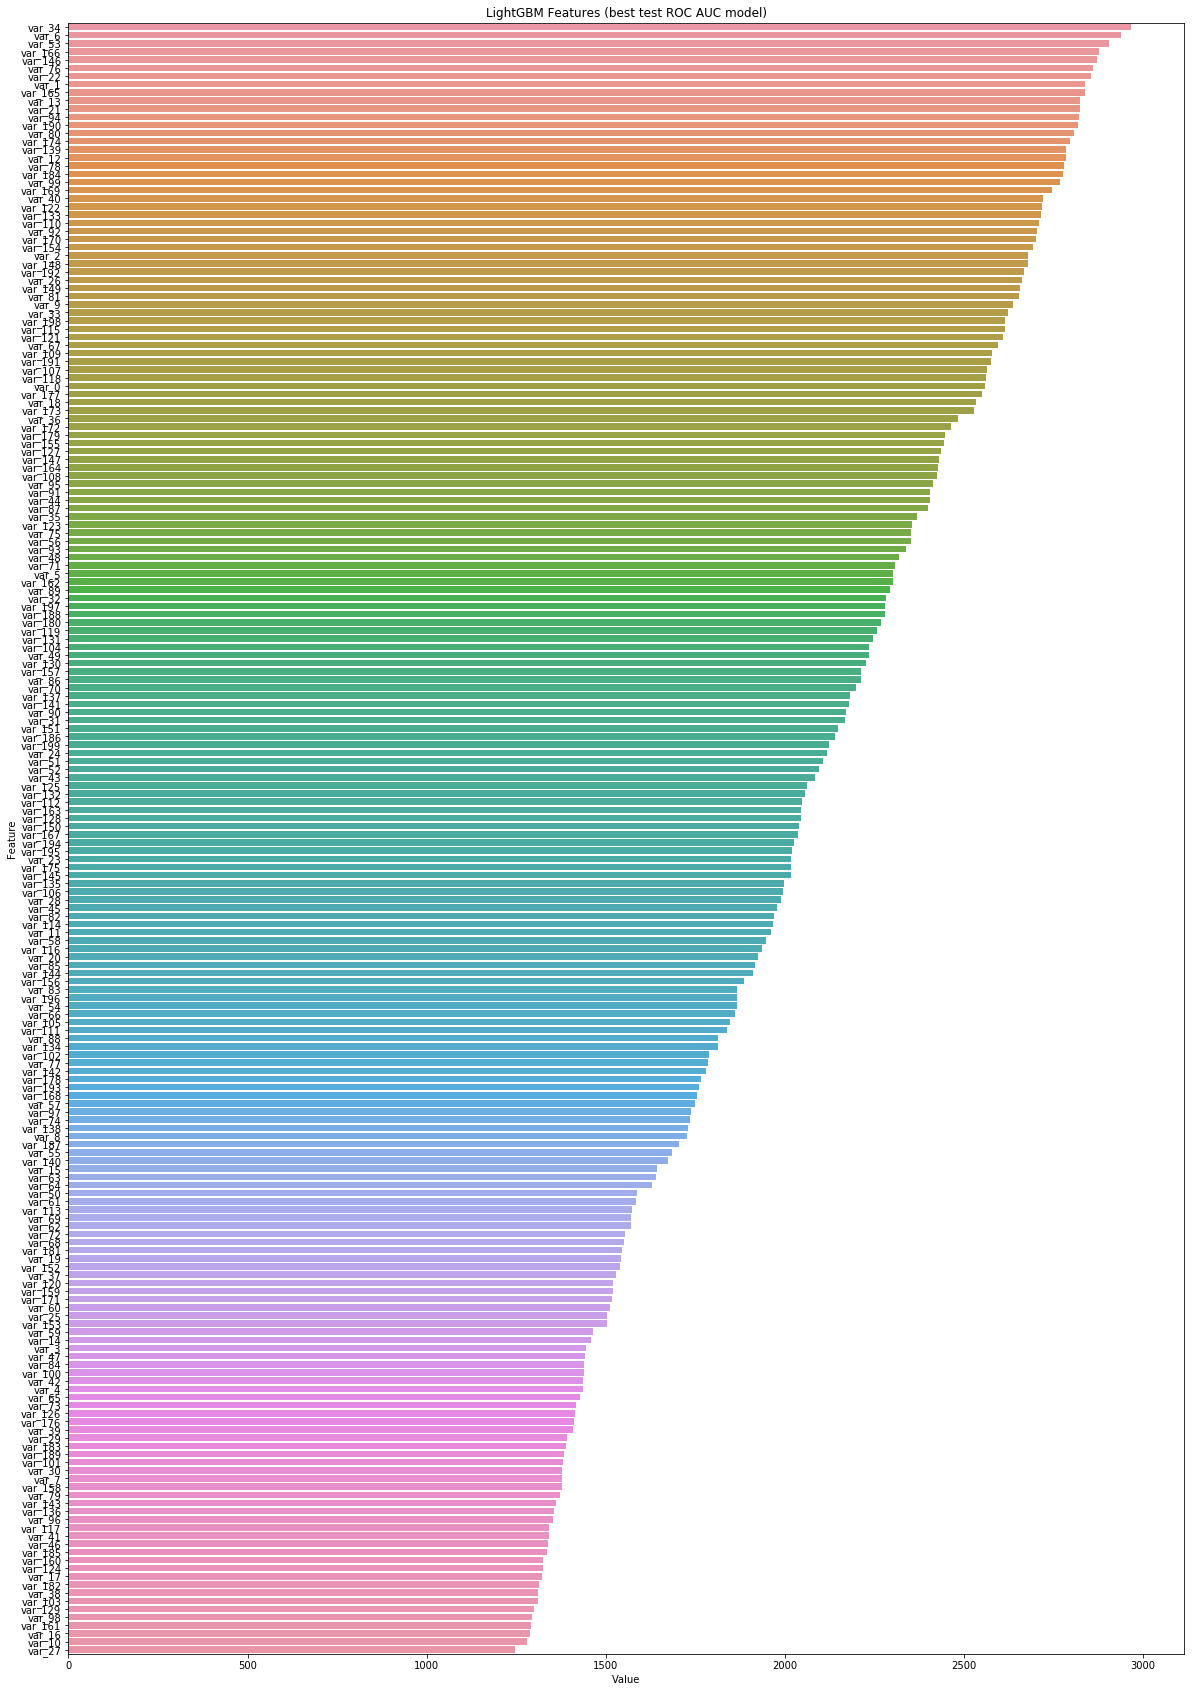

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# All features importance
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importance(),filtered_training_features.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 30))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (best test ROC AUC model)')
plt.savefig('lgbm_importances-01.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()


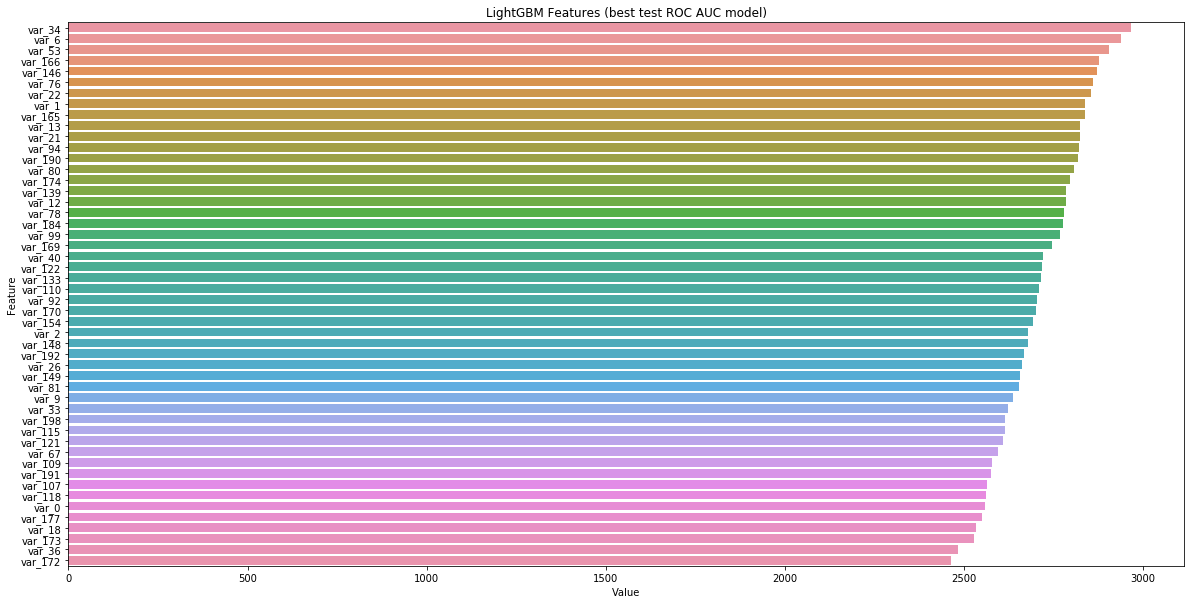

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 50 most important features
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importance(),filtered_training_features.columns)), columns=['Value','Feature'])
feature_imp = feature_imp[-50:]

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (best test ROC AUC model)')
plt.savefig('lgbm_importances-top-50.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()


### Kaggle submission

In [21]:
submission['target'] = predictions
submission.to_csv('submission.csv', index=False)